3-class label distribution (0=nature, 1=mixed, 2=anthro):
label_3
0    0.607809
2    0.226170
1    0.166022
Name: fraction, dtype: float64

high_level  purity                  
anthro      pure                        2572
            mixed                       1888
nature      pure                         200
            mixed                         11
            250505_0404_part2_26.wav       5
Name: count, dtype: int64
Shape: (11372, 13)

Columns: ['path', 'label_3', 'label_binary', 'high_level', 'category', 'purity', 'low_frac', 'high_frac', 'mean_flatness', 'high_flat_frame_frac', 'peak_count', 'rhythmic', 'too_short']

Binary label distribution (0=nature, 1=contaminated):
label_binary
0    0.607809
1    0.392191
Name: fraction, dtype: float64
Train size: 9097
Test size: 2275

=== 3-class report (0=nature,1=mixed,2=anthro) ===
              precision    recall  f1-score   support

           0      0.706     0.792     0.747      1383
           1      0.224     0.183     0.201  

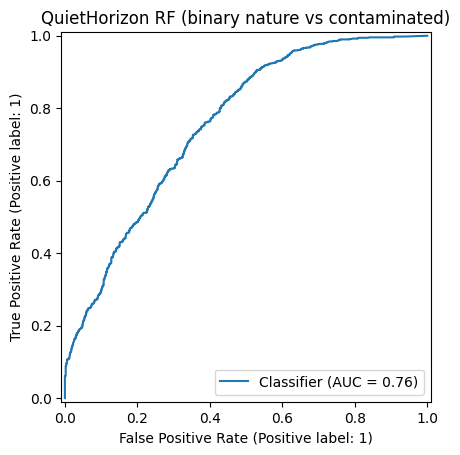

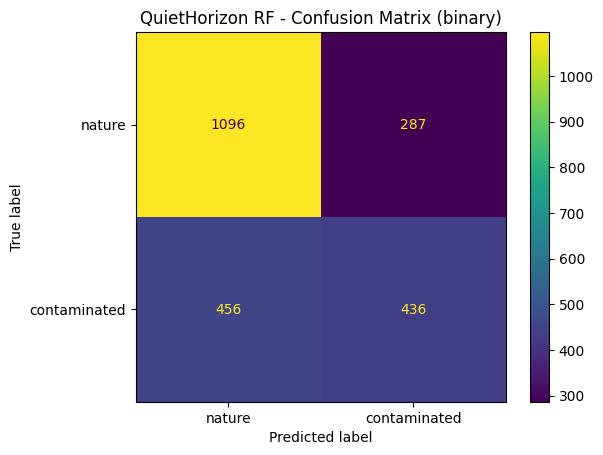

high_frac                 0.325
low_frac                  0.315
mean_flatness             0.313
peak_count                0.038
rhythmic                  0.008
high_flat_frame_frac      0.001


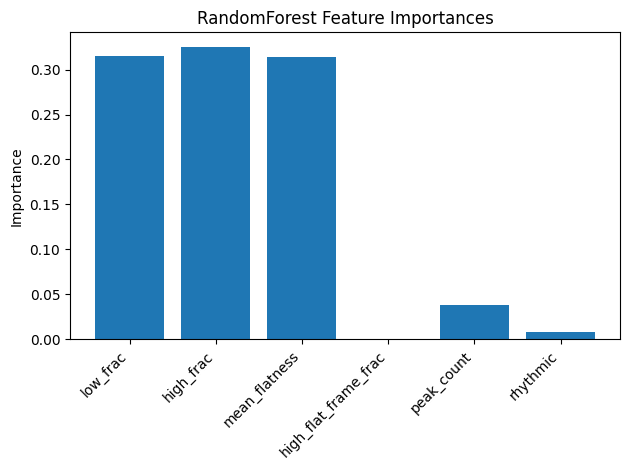


=== Logistic Regression report (binary nature vs contaminated) ===
              precision    recall  f1-score   support

           0      0.617     0.986     0.759      1383
           1      0.697     0.052     0.096       892

    accuracy                          0.619      2275
   macro avg      0.657     0.519     0.427      2275
weighted avg      0.648     0.619     0.499      2275

ROC-AUC (LogReg): 0.585


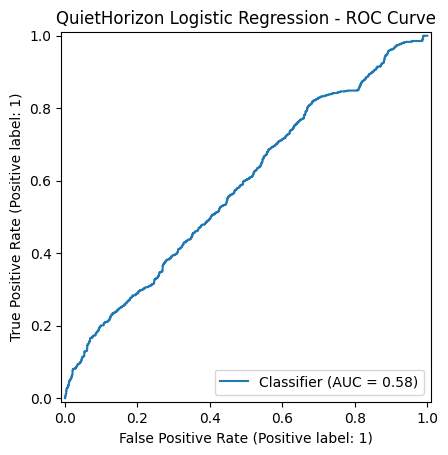


Saved RandomForest model to: models\quiet_horizon_rf.pkl


In [34]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    RocCurveDisplay,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import joblib

# Make prints easier to read
pd.set_option("display.max_columns", 50)

# -----------------------------
# 1. Load data
# -----------------------------
df = pd.read_csv("quiet_horizon_features_multiclass.csv")

# Drop too-short clips
df = df[df["too_short"] == 0].reset_index(drop=True)

# Keep only valid 3-class labels
df = df[df["label_3"].isin([0, 1, 2])].reset_index(drop=True)

print("3-class label distribution (0=nature, 1=mixed, 2=anthro):")
print(df["label_3"].value_counts(normalize=True).rename("fraction"))
print()

print(df[["high_level", "purity"]].value_counts().head())
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())

# If you want a quick binary distribution:
print("\nBinary label distribution (0=nature, 1=contaminated):")
print(df["label_binary"].value_counts(normalize=True).rename("fraction"))

# -----------------------------
# 2. Features and labels
# -----------------------------
feature_cols = [
    "low_frac",
    "high_frac",
    "mean_flatness",
    "high_flat_frame_frac",
    "peak_count",
    "rhythmic",
]

X = df[feature_cols].values
y3 = df["label_3"].values         # 0=nature, 1=mixed, 2=anthro
y_bin = df["label_binary"].values # 0=nature, 1=contaminated

# Split all three arrays in sync
X_train, X_test, y3_train, y3_test, ybin_train, ybin_test = train_test_split(
    X, y3, y_bin,
    test_size=0.2,
    random_state=42,
    stratify=y3,
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

# -----------------------------
# 3. RandomForest (3-class)
# -----------------------------
rf = RandomForestClassifier(
    n_estimators=400,
    class_weight="balanced",
    random_state=42,
)
rf.fit(X_train, y3_train)

y3_pred = rf.predict(X_test)

print("\n=== 3-class report (0=nature,1=mixed,2=anthro) ===")
print(classification_report(y3_test, y3_pred, digits=3))

print("\n3-class confusion matrix:")
print(confusion_matrix(y3_test, y3_pred))

# -----------------------------
# 4. Binary evaluation (nature vs contaminated)
# -----------------------------
# Collapse labels: 0 -> 0 (nature), 1 & 2 -> 1 (contaminated)
y_bin_test = (y3_test != 0).astype(int)
y_bin_pred = (y3_pred != 0).astype(int)

print("\n=== Binary nature vs contaminated (from RF) ===")
print(classification_report(y_bin_test, y_bin_pred, digits=3))
print(confusion_matrix(y_bin_test, y_bin_pred))

# For ROC, we need probabilities for "contaminated"
proba_3 = rf.predict_proba(X_test)  # shape: (N, 3)
# contaminated probability = P(mixed) + P(anthro) = proba[:,1] + proba[:,2]
y_proba_contam = proba_3[:, 1] + proba_3[:, 2]

auc_rf = roc_auc_score(y_bin_test, y_proba_contam)
print(f"\nRF ROC-AUC (binary nature vs contaminated): {auc_rf:.3f}")

RocCurveDisplay.from_predictions(y_bin_test, y_proba_contam)
plt.title("QuietHorizon RF (binary nature vs contaminated)")
plt.show()

cm_bin = confusion_matrix(y_bin_test, y_bin_pred)
disp = ConfusionMatrixDisplay(cm_bin, display_labels=["nature", "contaminated"])
disp.plot(values_format="d")
plt.title("QuietHorizon RF - Confusion Matrix (binary)")
plt.show()

# -----------------------------
# 5. Feature importances
# -----------------------------
importances = rf.feature_importances_
for name, imp in sorted(zip(feature_cols, importances), key=lambda x: -x[1]):
    print(f"{name:25s} {imp:.3f}")

plt.bar(range(len(feature_cols)), importances)
plt.xticks(range(len(feature_cols)), feature_cols, rotation=45, ha="right")
plt.ylabel("Importance")
plt.title("RandomForest Feature Importances")
plt.tight_layout()
plt.show()

# -----------------------------
# 6. Logistic Regression baseline (binary only)
# -----------------------------
log_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500)),
])

log_reg.fit(X_train, ybin_train)

y_pred_lr = log_reg.predict(X_test)
y_proba_lr = log_reg.predict_proba(X_test)[:, 1]  # P(contaminated)

print("\n=== Logistic Regression report (binary nature vs contaminated) ===")
print(classification_report(y_bin_test, y_pred_lr, digits=3))

auc_lr = roc_auc_score(y_bin_test, y_proba_lr)
print(f"ROC-AUC (LogReg): {auc_lr:.3f}")

RocCurveDisplay.from_predictions(y_bin_test, y_proba_lr)
plt.title("QuietHorizon Logistic Regression - ROC Curve")
plt.show()

# -----------------------------
# 7. Save RF model
# -----------------------------
os.makedirs("models", exist_ok=True)
MODEL_PATH = os.path.join("models", "quiet_horizon_rf.pkl")

joblib.dump(
    {
        "model": rf,
        "features": feature_cols,
    },
    MODEL_PATH,
)

print(f"\nSaved RandomForest model to: {MODEL_PATH}")
